### Implementation details for Atari games
1. StableBaseline3 wrappers:
  * NoopResetEnv: samples initial states by taking a random number (between 1 and 30) of no-ops on reset.
  * MaxAndSkipEnv: skips 4 frames by default, repeats the agent's last action on the skipped frames, and sums up the rewards in the skipped frames.
  * EpisodicLifeEnv: in the games where there are a life counter such as breakout, this wrapper marks the end of life as the end of episode.
  * FireResetEnv: takes the FIRE action on reset for environments that are fixed until firing.
  * WarpFrame: warps extracts the Y channel of the 210x160 pixel images and resizes it to 84x84.

    We use the *ResizeObservation* and *GrayScaleObservation* wrappers to achieve the same purpose.

  * ClipRewardEnv: clips all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged.
  * FrameStack: stacks m last frames such that the agent can infer the velocity and directions of moving objects.

2. Shared CNN network for the policy and value functions

  The policy and value functions share parameters by constructing a policy head and a value head using the hidden features. Such a parameter-sharing paradigm obviously computes faster when compared to setting completely separate networks.

3. Scaling the Images to Range [0, 1]

  The input data has the range of [0,255], but it is divided by 255 to be in the range of [0,1]



In [ ]:
!pip install --upgrade gym[atari]
!pip install stable_baselines3
!pip install atari-py==0.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827619 sha256=7bd8f94c361e174cbe364be9b83ab3dd16afb919970a374a11db001f8ba9baa2
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
import argparse
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)

In [ ]:
def make_env(env_id, seed, idx, record_video=False):
    def thunk():
        env = gym.make(env_id, render_mode='rgb_array')
        if record_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{env_id}")

        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # Preprocessing wraps
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = ClipRewardEnv(env)

        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)

        return env # obs 4x84x84 : 4 FrameStack, 84x84 Resize

    return thunk

In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

In [ ]:
class PPOAgent(nn.Module):
    def __init__(self, envs):
        super(PPOAgent, self).__init__()

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64*7*7, 512)),
            nn.ReLU(),
        )

        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1.0)

    def get_value(self, x):
        hidden = self.network(x / 255.0)
        return self.critic(hidden)

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits) # soft-max distribution

        if action is None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.critic(hidden)

        return action, log_prob, entropy, value

In [ ]:
config = argparse.Namespace()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.seed = 1

config.env_id = 'BreakoutNoFrameskip-v4'
config.num_envs = 8
config.num_steps = 128     # The number of steps to run in each env to policy rollout

config.batch_size = config.num_envs * config.num_steps
config.num_minibatches = 4 # the number of mini-batches
config.minibatch_size = config.batch_size // config.num_minibatches

config.total_timesteps = 10000000
config.num_updates = config.total_timesteps // config.batch_size
config.num_epochs = 4

config.learning_rate = 3e-4
config.gamma = 0.99
config.anneal_lr = True    # Learning rate annealing for policy and value networks
config.gae = True         # Generalized Advantage Estimation
config.gae_lambda = 0.95

config.norm_adv = True     # Advantages normalization
config.clip_coef = 0.1     # The surrogate clipping coefficient (policy and value function)
config.clip_vloss = True   # Use clip_coef to clip value function

config.vf_coef = 0.5       # The value coefficient to calculate loss
config.ent_coef = 0.01     # Encourages the policy to explore a diverse set of actions
config.max_grad_norm = 0.5 # The maximum normalization for the gradient clipping
config.target_kl = 0.015   # The target KL divergence threshold

config.track = True

Connect to Weights and Biases

In [ ]:
if config.track:
    !pip install wandb

In [ ]:
if config.track:
    import wandb
    wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
if config.track:
    wandb.init(
        project='ppo-implementation-details',
        config=config,
        name=config.env_id,
        monitor_gym=True,
        save_code=True,
    )

wandb: Currently logged in as: jupit. Use `wandb login --relogin` to force relogin


In [ ]:
# Seeding
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

envs = gym.vector.SyncVectorEnv(
    [make_env(config.env_id, config.seed + i, i, record_video=True) for i in range(config.num_envs)]
)

print("Observation space:", envs.single_observation_space)
print("Action space:", envs.single_action_space)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

agent = PPOAgent(envs).to(config.device)
optimizer = optim.Adam(agent.parameters(), lr=config.learning_rate, eps=1e-5)

/usr/local/lib/python3.10/dist-packages/ale_py/roms/__init__.py:118: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`. For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  path = _resolve_rom(name)


Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space: Discrete(4)


In [ ]:
def compute_gae_advantages(rewards, values, next_return, dones, num_steps, gamma=0.99, gae_lambda=0.95):
    gae_advantages = torch.zeros_like(rewards)

    gae = 0
    for t in reversed(range(num_steps)):
        delta = rewards[t] + gamma * next_return * (1 - dones[t]) - values[t]
        gae = delta + gamma * gae_lambda * gae * (1 - dones[t])
        gae_advantages[t] = gae
        next_return = values[t]

    returns = gae_advantages + values
    return returns, gae_advantages

In [ ]:
def compute_n_step_return(rewards, values, next_return, dones, num_steps, gamma=0.99):
      returns = torch.zeros_like(rewards)

      for t in reversed(range(num_steps)):
          returns[t] = rewards[t] + gamma * next_return * (1 - dones[t])
          next_return = returns[t]

      advantages = returns - values
      return returns, advantages

In [ ]:
def PPOTrain(envs, optimizer, config):
  global global_step

  # Storage setup
  observations = torch.zeros((config.num_steps, config.num_envs) + envs.single_observation_space.shape).to(config.device)
  actions = torch.zeros((config.num_steps, config.num_envs) + envs.single_action_space.shape, dtype=torch.long).to(config.device)
  rewards = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  dones = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  values = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  logprobs = torch.zeros((config.num_steps, config.num_envs)).to(config.device)

  for update in range(config.num_updates):
      # Update learning rate
      if config.anneal_lr:
          lr_frac = 1.0 - update / config.num_updates
          optimizer.param_groups[0]["lr"] = lr_frac * config.learning_rate

      # Do n-steps
      episodic_return = 0
      obs = envs.reset()[0]
      for step in range(config.num_steps):
          global_step += config.num_envs

          with torch.no_grad():
              obs_tensor = torch.Tensor(obs).to(config.device)
              action, logprob, _, value = agent.get_action_and_value(obs_tensor)

          next_obs, reward, done, _, _ = envs.step(action.cpu().numpy())

          # Save batch
          observations[step] = obs_tensor
          actions[step] = torch.tensor(action, dtype=torch.long).to(config.device)
          rewards[step] = torch.Tensor(reward).to(config.device)
          dones[step] = torch.Tensor(done).to(config.device)
          values[step] = torch.Tensor(value.flatten()).to(config.device)
          logprobs[step] = torch.Tensor(logprob).to(config.device)

          episodic_return += reward.mean()
          obs = next_obs

      print(f"global_step={global_step}, episodic_return={episodic_return}")
      if config.track:
          wandb.log({'episodic_return': episodic_return})

      # Generalized Advantage Estimation
      with torch.no_grad():
          next_obs_tensor = torch.Tensor(next_obs).to(config.device)
          next_value = agent.get_value(next_obs_tensor).reshape(1, -1)

          if config.gae:
              returns, advantages = compute_gae_advantages(rewards, values, next_value, dones, config.num_steps, config.gamma, config.gae_lambda)
          else:
              returns, advantages = compute_n_step_return(rewards, values, next_value, dones, config.num_steps, config.gamma)

      # Flatten the batch: num_steps * num_envs
      b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
      b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
      b_returns = returns.reshape(-1)
      b_values = values.reshape(-1)
      b_logprobs = logprobs.reshape(-1)
      b_advantages = advantages.reshape(-1)

      clip_fracs = []

      # Shuffles the indices of the batch and breaks it into mini-batches
      batch_inds = np.arange(config.batch_size)
      for epoch in range(config.num_epochs):
          np.random.shuffle(batch_inds)

          for start in range(0, config.batch_size, config.minibatch_size):
              end = start + config.minibatch_size
              minibatch_inds = batch_inds[start:end]

              # Mini-batches: targets
              mb_observations = b_observations[minibatch_inds]
              mb_actions = b_actions[minibatch_inds]
              mb_returns = b_returns[minibatch_inds]
              mb_values = b_values[minibatch_inds]
              mb_logprobs = b_logprobs[minibatch_inds]
              mb_advantages = b_advantages[minibatch_inds]

              # Advantages normalization
              if config.norm_adv:
                  mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

              # Predictions
              _, mb_logprobs_pred, mb_entropy_pred, mb_values_pred = agent.get_action_and_value(mb_observations, mb_actions)

              log_ratio = mb_logprobs_pred - mb_logprobs
              ratio = log_ratio.exp()

              with torch.no_grad():
                  clip_fracs += [((ratio - 1.0).abs() > config.clip_coef).float().mean().item()]

              # Policy loss
              pg_loss_unclipped = -mb_advantages * ratio
              pg_loss_clipped = -mb_advantages * torch.clamp(ratio, 1 - config.clip_coef, 1 + config.clip_coef)
              pg_loss = torch.max(pg_loss_unclipped, pg_loss_clipped).mean()

              # Value loss
              mb_values_pred = mb_values_pred.view(-1)

              v_loss_sqrt = (mb_values_pred - mb_returns) ** 2 # Unclipped
              if config.clip_vloss:
                  # Ensure that the value function updates do not deviate too far from the original values
                  v_clipped = torch.clamp(mb_values_pred, mb_values - config.clip_coef, mb_values + config.clip_coef)
                  v_loss_clipped = (v_clipped - mb_returns) ** 2
                  v_loss_sqrt = torch.max(v_loss_sqrt, v_loss_clipped)

              v_loss = 0.5 * v_loss_sqrt.mean()

              # Entropy Loss
              entropy_loss = mb_entropy_pred.mean()

              # Overall Loss
              loss = pg_loss - config.ent_coef * entropy_loss + config.vf_coef * v_loss

              optimizer.zero_grad()
              loss.backward()

              # Global Gradient Clipping
              nn.utils.clip_grad_norm_(agent.parameters(), config.max_grad_norm)

              optimizer.step()

          with torch.no_grad():
            # old_approx_kl = (-logratio).mean()
            approx_kl = ((ratio - 1) - log_ratio).mean()

          # Early stop using approx_kl
          if config.target_kl is not None:
                if approx_kl > config.target_kl:
                    break

      y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
      var_y = np.var(y_true)
      explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

      if config.track:
          metrics = {
              "GLOBAL STEP": global_step,
              "loss": loss.item(),
              "learning_rate": optimizer.param_groups[0]["lr"],
              "value_loss": v_loss.item(),
              "policy_loss": pg_loss.item(),
              "entropy": entropy_loss.item(),
              "approx_kl": approx_kl.item(),
              "clip_frac": np.mean(clip_fracs),
              "explained_variance": explained_var
          }
          wandb.log(metrics)
          print(metrics)

In [ ]:
global_step = 0

In [ ]:
PPOTrain(envs, optimizer, config)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


global_step=1024, episodic_return=1.375
{'GLOBAL STEP': 1024, 'loss': 0.008341856300830841, 'learning_rate': 0.0003, 'value_loss': 0.0436847060918808, 'policy_loss': 0.0003598406910896301, 'entropy': 1.3860337734222412, 'approx_kl': 0.00023561599664390087, 'clip_frac': 0.0, 'explained_variance': 0.0025739073753356934}
Moviepy - Building video /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-0.mp4
global_step=2048, episodic_return=1.5
{'GLOBAL STEP': 2048, 'loss': 0.007927998900413513, 'learning_rate': 0.00029996927803379415, 'value_loss': 0.041306816041469574, 'policy_loss': 0.001129964366555214, 'entropy': 1.3855373859405518, 'approx_kl': 0.000328300753608346, 'clip_frac': 0.0, 'explained_variance': 0.00453495979309082}
global_step=3072, episodic_return=1.0
{'GLOBAL STEP': 3072, 'loss': 0.0027075912803411484, 'learning_rate': 0.0002999385560675883, 'value_loss': 0.03200463205575943, 'policy_loss': 0.000537920743227005, 'entropy': 1.3832645416259766, 'approx_kl': 0.0007572548929601908, 'clip_frac': 0.0, 'explained_variance': -0.008108019828796387}
Moviepy - Building video /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-1.mp4
global_step=4096, episodic_return=1.125
{'GLOBAL STEP': 4096, 'loss': -9.072571992874146e-05, 'learning_rate': 0.00029990783410138245, 'value_loss': 0.031689226627349854, 'policy_loss': -0.002108687534928322, 'entropy': 1.3826651573181152, 'approx_kl': 0.00031089503318071365, 'clip_frac': 0.0, 'explained_variance': 0.08048063516616821}
global_step=5120, episodic_return=0.5
{'GLOBAL STEP': 5120, 'loss': -0.011330533772706985, 'learning_rate': 0.0002998771121351766, 'value_loss': 0.016012266278266907, 'policy_loss': -0.005479017272591591, 'entropy': 1.3857650756835938, 'approx_kl': 0.0024353854823857546, 'clip_frac': 0.0068359375, 'explained_variance': 0.18967854976654053}
global_step=6144, episodic_return=1.5
{'GLOBAL STEP': 6144, 'loss': 0.01292538084089756, 'learning_rate': 0.0002998463901689708, 'value_loss': 0.04965880513191223, 'policy_loss': 0.0019359495490789413, 'entropy': 1.3839

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-8.mp4
global_step=16384, episodic_return=0.5
{'GLOBAL STEP': 16384, 'loss': -0.011801560409367085, 'learning_rate': 0.0002995391705069124, 'value_loss': 0.013786153867840767, 'policy_loss': -0.005020490847527981, 'entropy': 1.3674147129058838, 'approx_kl': 0.001863222336396575, 'clip_frac': 0.0, 'explained_variance': 0.5197344422340393}
global_step=17408, episodic_return=0.75
{'GLOBAL STEP': 17408, 'loss': -0.013164922595024109, 'learning_rate': 0.0002995084485407066, 'value_loss': 0.010022570379078388, 'policy_loss': -0.004398193210363388, 'entropy': 1.3778014183044434, 'approx_kl': 0.0026319746393710375, 'clip_frac': 0.141845703125, 'explained_variance': 0.8138176798820496}
global_step=18432, episodic_return=0.625
{'GLOBAL STEP': 18432, 'loss': -0.018665911629796028, 'learning_rate': 0.00029947772657450074, 'value_loss': 0.013140741735696793, 'policy_loss': -0.011534206569194794, 'entropy':

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-27.mp4
global_step=43008, episodic_return=1.625
{'GLOBAL STEP': 43008, 'loss': -0.013836221769452095, 'learning_rate': 0.0002987403993855606, 'value_loss': 0.02071397379040718, 'policy_loss': -0.010858388617634773, 'entropy': 1.333482027053833, 'approx_kl': 0.0009515343699604273, 'clip_frac': 0.04248046875, 'explained_variance': 0.817487508058548}
global_step=44032, episodic_return=1.375
{'GLOBAL STEP': 44032, 'loss': -0.015500038862228394, 'learning_rate': 0.0002987096774193548, 'value_loss': 0.01716093346476555, 'policy_loss': -0.010747676715254784, 'entropy': 1.3332829475402832, 'approx_kl': 0.0010705147869884968, 'clip_frac': 0.0498046875, 'explained_variance': 0.838354617357254}
global_step=45056, episodic_return=1.125
{'GLOBAL STEP': 45056, 'loss': -0.017877189442515373, 'learning_rate': 0.000298678955453149, 'value_loss': 0.005839701741933823, 'policy_loss': -0.0075016990303993225, 'en

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-64.mp4
global_step=126976, episodic_return=2.25
{'GLOBAL STEP': 126976, 'loss': -0.01122914720326662, 'learning_rate': 0.000296221198156682, 'value_loss': 0.028052115812897682, 'policy_loss': -0.015665756538510323, 'entropy': 0.9589449167251587, 'approx_kl': 0.004571549594402313, 'clip_frac': 0.144287109375, 'explained_variance': 0.7766051590442657}
global_step=128000, episodic_return=2.25
{'GLOBAL STEP': 128000, 'loss': -0.014412778429687023, 'learning_rate': 0.00029619047619047615, 'value_loss': 0.029690394178032875, 'policy_loss': -0.01933998614549637, 'entropy': 0.9917988777160645, 'approx_kl': 0.005109517835080624, 'clip_frac': 0.13330078125, 'explained_variance': 0.6181742548942566}
global_step=129024, episodic_return=2.0
{'GLOBAL STEP': 129024, 'loss': -0.010285533033311367, 'learning_rate': 0.0002961597542242703, 'value_loss': 0.030636990442872047, 'policy_loss': -0.016095470637083054

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-125.mp4
global_step=338944, episodic_return=2.5
{'GLOBAL STEP': 338944, 'loss': -0.021389666944742203, 'learning_rate': 0.0002898617511520737, 'value_loss': 0.03257665038108826, 'policy_loss': -0.028851360082626343, 'entropy': 0.8826632499694824, 'approx_kl': 0.005842084065079689, 'clip_frac': 0.136962890625, 'explained_variance': 0.8010085225105286}
global_step=339968, episodic_return=2.375
{'GLOBAL STEP': 339968, 'loss': -0.010544268414378166, 'learning_rate': 0.00028983102918586786, 'value_loss': 0.04071873798966408, 'policy_loss': -0.021948598325252533, 'entropy': 0.8955039978027344, 'approx_kl': 0.005293097347021103, 'clip_frac': 0.123046875, 'explained_variance': 0.6508347988128662}
global_step=340992, episodic_return=2.5
{'GLOBAL STEP': 340992, 'loss': -0.012664735317230225, 'learning_rate': 0.00028980030721966203, 'value_loss': 0.04350842535495758, 'policy_loss': -0.02545826882123947,

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-216.mp4
global_step=740352, episodic_return=3.375
{'GLOBAL STEP': 740352, 'loss': -0.010296376422047615, 'learning_rate': 0.00027781874039938556, 'value_loss': 0.03421899676322937, 'policy_loss': -0.01956366002559662, 'entropy': 0.7842215299606323, 'approx_kl': 0.00900246948003769, 'clip_frac': 0.159423828125, 'explained_variance': 0.6927576065063477}
global_step=741376, episodic_return=2.75
{'GLOBAL STEP': 741376, 'loss': 0.0016850214451551437, 'learning_rate': 0.0002777880184331797, 'value_loss': 0.04811061546206474, 'policy_loss': -0.014509614557027817, 'entropy': 0.7860672473907471, 'approx_kl': 0.006425480358302593, 'clip_frac': 0.13037109375, 'explained_variance': 0.5889092087745667}
global_step=742400, episodic_return=2.875
{'GLOBAL STEP': 742400, 'loss': -0.0019038598984479904, 'learning_rate': 0.00027775729646697386, 'value_loss': 0.04809364303946495, 'policy_loss': -0.01829726435244

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4/rl-video-episode-343.mp4
global_step=1556480, episodic_return=3.25
{'GLOBAL STEP': 1556480, 'loss': -0.0058787427842617035, 'learning_rate': 0.00025333333333333333, 'value_loss': 0.05942506343126297, 'policy_loss': -0.027923084795475006, 'entropy': 0.7668188810348511, 'approx_kl': 0.010937782004475594, 'clip_frac': 0.14697265625, 'explained_variance': 0.5864250957965851}
global_step=1557504, episodic_return=3.375
{'GLOBAL STEP': 1557504, 'loss': 0.002182338386774063, 'learning_rate': 0.00025330261136712745, 'value_loss': 0.07813341915607452, 'policy_loss': -0.028968827798962593, 'entropy': 0.79155433177948, 'approx_kl': 0.008572287857532501, 'clip_frac': 0.14990234375, 'explained_variance': 0.5175120830535889}
global_step=1558528, episodic_return=3.25
{'GLOBAL STEP': 1558528, 'loss': -0.011157877743244171, 'learning_rate': 0.0002532718894009216, 'value_loss': 0.04404713213443756, 'policy_loss': -0.02546620368

In [ ]:
envs.close()
if config.track: wandb.finish()

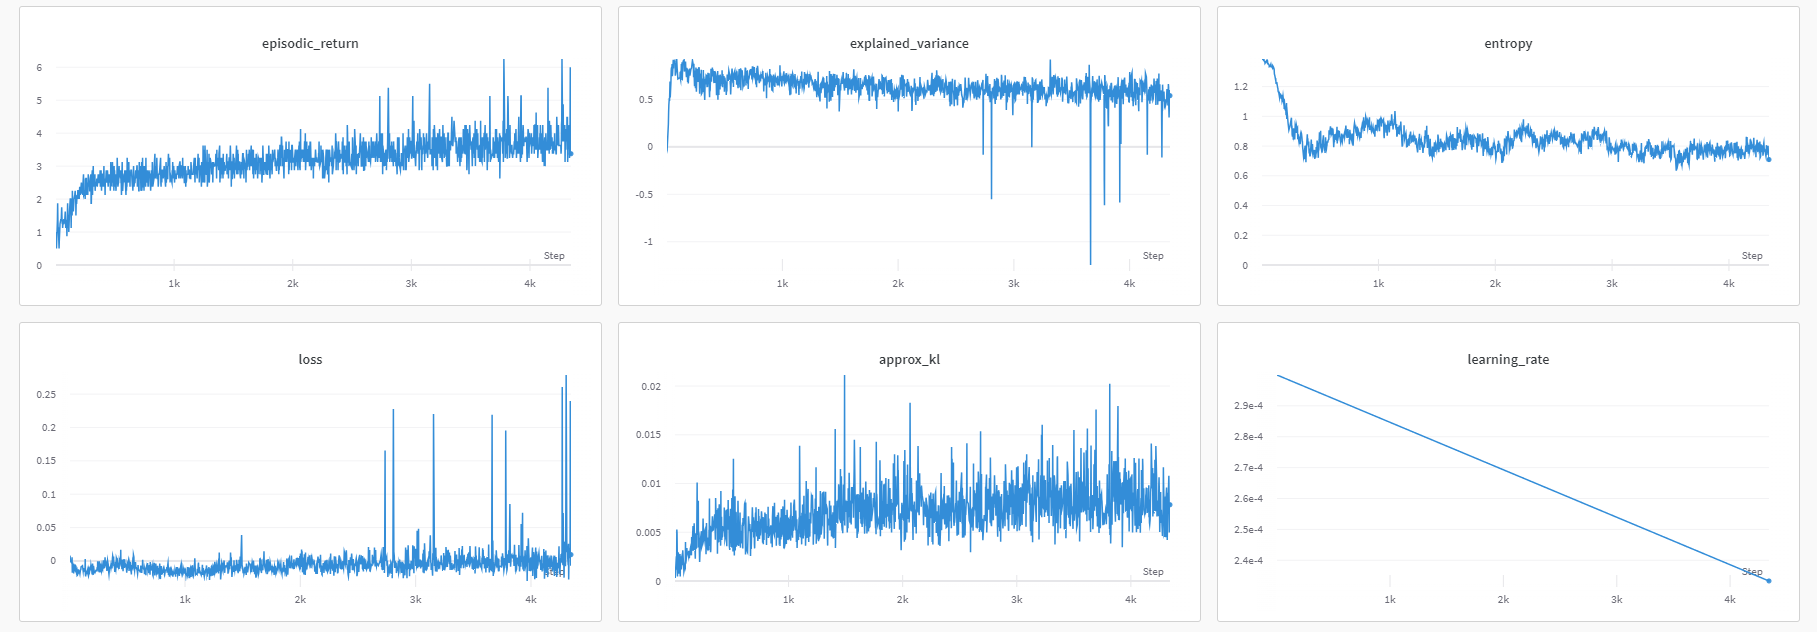

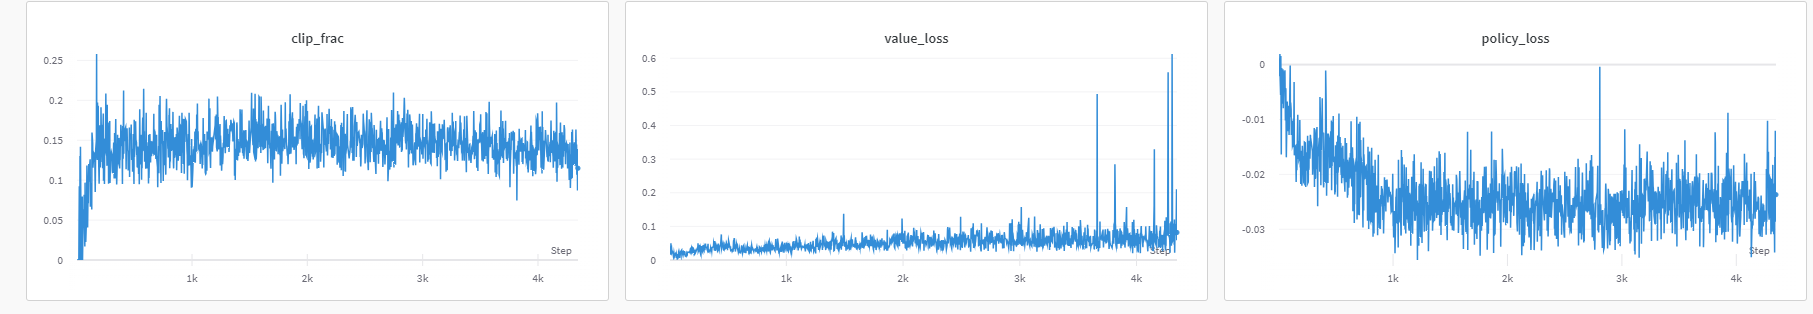